In [13]:
from aeon.datasets import load_airline
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
import numpy as np
from aeon.datasets import load_airline
# from aeon.forecasting.arima import ARIMA
from matplotlib import pyplot as plt
from aeon.forecasting.arima import AutoARIMA
from aeon.forecasting.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series
from aeon.transformations.detrend import Deseasonalizer
from all_functions import *
warnings.filterwarnings("ignore")
%matplotlib inline
horizon = 12

def mcpm_func(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

In [14]:
import os

# pastas = [
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinac',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleodiesel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/etanolhidratado',
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinadeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/glp',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleocombustivel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/querosenedeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/queroseneiluminante'
#           ]

pastas = [
          '../results/varma/rolling/gasolinac',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleodiesel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/etanolhidratado',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/gasolinadeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/glp',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleocombustivel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/querosenedeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/queroseneiluminante'
          ]


dfs_por_transformacao = {}

for pasta in pastas:
    if os.path.isdir(pasta):
        for arquivo in os.listdir(pasta):
            if arquivo.endswith('.csv'):
                caminho_arquivo = os.path.join(pasta, arquivo)
                df = pd.read_csv(caminho_arquivo, delimiter=';')
                
                for transformacao, grupo in df.groupby('DATA'):
                    if transformacao not in dfs_por_transformacao:
                        dfs_por_transformacao[transformacao] = grupo.copy()
                    else:
                        dfs_por_transformacao[transformacao] = pd.concat(
                            [dfs_por_transformacao[transformacao], grupo], ignore_index=True
                        )


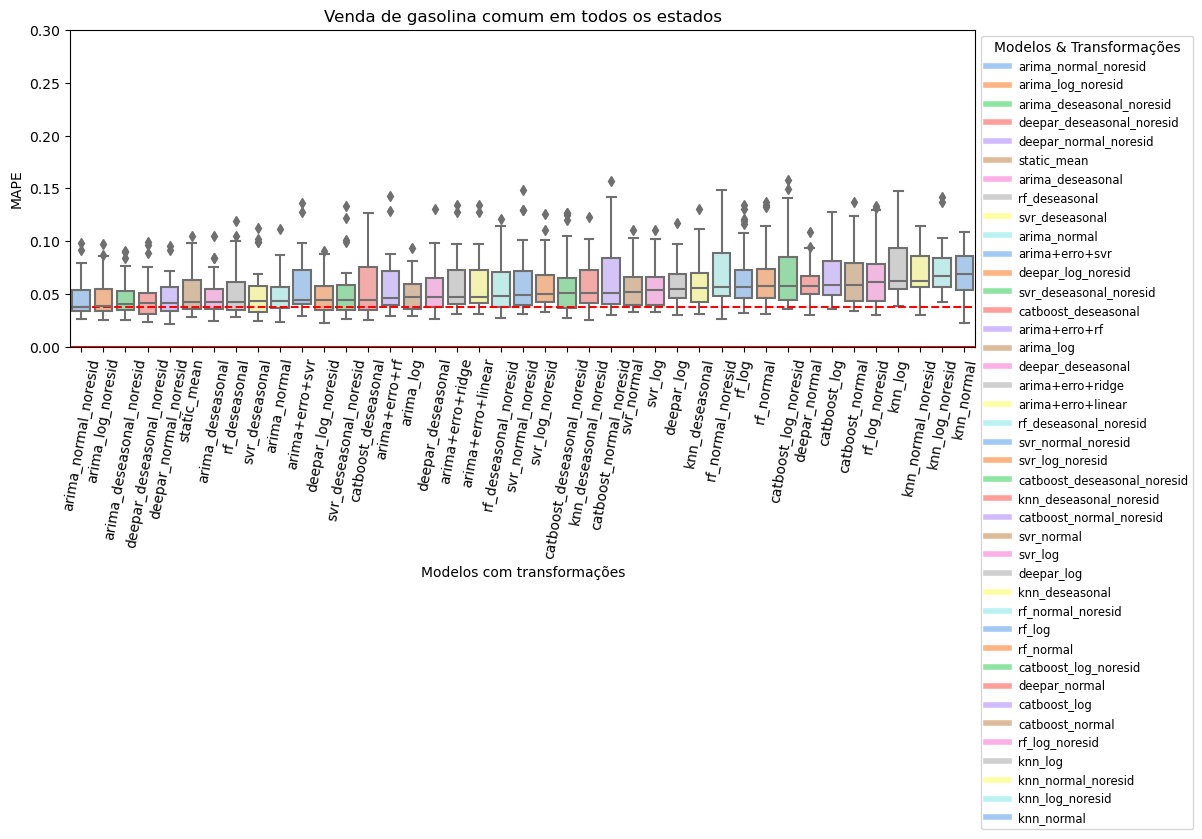

In [15]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path_data = "../datasets/venda/mensal/uf"
# cores_uf = {
#     'AC': 'green', 'AL': 'green', 'AP': 'green', 'AM': 'green', 'BA': 'green',
#     'CE': 'green', 'DF': 'green', 'ES': 'green', 'GO': 'green', 'MA': 'green',
#     'MT': 'green', 'MS': 'green', 'MG': 'green', 'PA': 'green', 'PB': 'green',
#     'PR': 'blue', 'PE': 'green', 'PI': 'green', 'RJ': 'green', 
#     'RN': 'green', 'RS': 'green', 'RO': 'green', 'RR': 'green', 
#     'SC': 'green', 'SP': 'red', 'SE': 'green', 'TO': 'green'
# }

def safe_eval(preds):
    try:
        # Remover quebras de linha e espaços desnecessários
        preds_clean = preds.replace('\n', ' ').replace('  ', ' ')
        # Remover espaços entre números
        preds_clean = ' '.join(preds_clean.split())
        preds_clean = preds_clean.replace(' ', ',')
        return ast.literal_eval(preds_clean)
    except Exception as e:
        print(f"Erro ao converter: {e}")
        return None
cores_uf = {
    'AC': 'red', 'AL': 'green', 'AP': 'blue', 'AM': 'yellow', 'BA': 'orange',
    'CE': 'purple', 'DF': 'brown', 'ES': 'pink', 'GO': 'gray', 'MA': 'olive',
    'MT': 'cyan', 'MS': 'magenta', 'MG': 'lime', 'PA': 'black', 'PB': 'navy',
    'PR': 'teal', 'PE': 'darkorange', 'PI': 'royalblue', 'RJ': 'salmon', 
    'RN': 'lightgreen', 'RS': 'violet', 'RO': 'gold', 'RR': 'sienna', 
    'SC': 'skyblue', 'SP': 'darkred', 'SE': 'dodgerblue', 'TO': 'tomato'
}

data_test = {}
data_preds = {}
def ler_dados(pastas_filtros):
    dfs_por_transformacao = []
    
    for item in pastas_filtros:
        pasta, filtro_data, coluna_filtro, label = item['pasta'], item['filtro'], item['coluna_filtro'], item['label']
        if os.path.isdir(pasta):
            for arquivo in os.listdir(pasta):
                if arquivo.endswith('.csv'):
                    derivado = pasta.split("/")[-1]
                    uf = arquivo.split("_")[1][:2]
                    caminho_arquivo = os.path.join(pasta, arquivo)
                    df = pd.read_csv(caminho_arquivo, sep=';')
                    # series = read_series(path_data+"/"+derivado+f"/mensal_{uf.lower()}_{derivado}.csv")
                    # train, test = train_test_stats(series, horizon)
                    # y_baseline = series[-horizon*2:-horizon].values
                    # data_test[f'{pasta.split("/")[2]+"-"+filtro_data}_{uf}'] = test
                    df_filtrado = df[df[coluna_filtro] == filtro_data]
                    if 'PREDS' in df_filtrado.columns:
                        predictions = df_filtrado['PREDS'].apply(safe_eval)
                        print(predictions)
                    else:
                        predictions = df_filtrado.loc[:, 'P1':'P12']
                        predictions = predictions.values.flatten().tolist()
                    # predictions = pd.Series(predictions, index=test.index)
                    # data_preds[f'{pasta.split("/")[3]+"-"+filtro_data}_{uf}'] = predictions
                    # mase_result = mase(test, predictions, y_baseline)
                    # df_filtrado["MASE"] = mase_result
                    df_filtrado['Filtro'] = label
                    dfs_por_transformacao.append(df_filtrado)
    
    return pd.concat(dfs_por_transformacao, ignore_index=True)

def gerar_boxplot(df, coluna_metrica, title="-", x_label = "Filters", cores_uf=None):
    plt.figure(figsize=(10, 6))
    
    if coluna_metrica == 'POCID':
        quartis = df.groupby('Filtro')[coluna_metrica].quantile(0.75)
        ordenacao_quartil = quartis.sort_values(ascending=False).index
        
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_quartil, ordered=True)
        ordenacao = ordenacao_quartil
    else:
        medianas = df.groupby('Filtro')[coluna_metrica].median()
        proximidade_mediana = (medianas - 0).abs()
        ordenacao_mediana = proximidade_mediana.sort_values().index
        
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_mediana, ordered=True)
        ordenacao = ordenacao_mediana

    # Criando boxplot
    sns.boxplot(x='Filtro', y=coluna_metrica, data=df, palette='pastel', order=df['Filtro'].cat.categories)
    
    # Adicionando pontos sobre o boxplot
    # sns.stripplot(x='Filtro', y=coluna_metrica, data=df, palette='dark', jitter=True, alpha=0.5, dodge=False, order=df['Filtro'].cat.categories)


    plt.title(f"{title}")
    plt.xlabel(x_label)
    plt.ylabel(coluna_metrica)
    plt.xticks(rotation=80)
    plt.tight_layout()

    # Ajustando os limites do eixo y
    if coluna_metrica == 'MAPE':
        plt.ylim(0, 0.6) if abs(max(medianas.values)) > 0.2 else plt.ylim(0, 0.3)
    elif coluna_metrica == 'PBE':
        plt.ylim(-40, 70) if abs(max(medianas.values)) > 20 else plt.ylim(-20, 20)
    elif coluna_metrica == 'POCID':
        plt.ylim(0, 100)
    
    plt.axhline(y=0, color='red', linestyle='-')  

    # Linha horizontal na mediana mais próxima
    mediana_prox = quartis.loc[ordenacao[0]] if coluna_metrica == 'POCID' else medianas.loc[ordenacao[0]]
    plt.axhline(y=mediana_prox, color='red', linestyle='--')  

    # Criando a legenda
    if cores_uf:
        # Ajustar a paleta de cores usando as cores de cores_uf, repetindo se necessário
        palette = [cores_uf[i % len(cores_uf)] for i in range(len(ordenacao))]
    else:
        palette = sns.color_palette("pastel", n_colors=len(ordenacao))  # Fallback para uma paleta padrão

    filtro_handles = [plt.Line2D([0], [0], color=palette[i], lw=4, label=filtro) for i, filtro in enumerate(ordenacao)]
    
    plt.legend(handles=filtro_handles, title='Modelos & Transformações', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
    
    plt.show()

produto = "gasolinac"
filtro = '2017-03_2018-02'
resultado_pasta = 'results'
pastas_filtros = [

    {'pasta': f'./results/arima/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_normal'},
    {'pasta': f'./results/arima/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_log'},
    {'pasta': f'./results/arima/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_deseasonal'},

    {'pasta': f'./results/knn/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'knn_normal'},
    {'pasta': f'./results/knn/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'knn_log'},
    {'pasta': f'./results/knn/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'knn_deseasonal'},

    {'pasta': f'./results/rf/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'rf_normal'},
    {'pasta': f'./results/rf/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'rf_log'},
    {'pasta': f'./results/rf/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'rf_deseasonal'},

    {'pasta': f'./results/deepar/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'deepar_normal'},
    {'pasta': f'./results/deepar/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'deepar_log'},
    {'pasta': f'./results/deepar/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'deepar_deseasonal'},

    {'pasta': f'./results/svr/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'svr_normal'},
    {'pasta': f'./results/svr/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'svr_log'},
    {'pasta': f'./results/svr/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'svr_deseasonal'},

    {'pasta': f'./results/catboost/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'catboost_normal'},
    {'pasta': f'./results/catboost/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'catboost_log'},
    {'pasta': f'./results/catboost/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'catboost_deseasonal'},

    # {'pasta': f'./combination/dynamic/{filtro}/{produto}', 'filtro': 'mean', 'coluna_filtro': 'DATA', 'label': 'dynamic_mean'},
    # {'pasta': f'./combination/dynamic_time/{filtro}/{produto}', 'filtro': 'mean', 'coluna_filtro': 'DATA', 'label': 'dynamic_time'},
    

    {'pasta': f'./combination/static/{filtro}/{produto}', 'filtro': 'mean', 'coluna_filtro': 'DATA', 'label': 'static_mean'},

    {'pasta': f'./combination_error/untagged/{filtro}/arima/deseasonal/{produto}', 'filtro': 'rf', 'coluna_filtro': 'DATA', 'label': 'arima+erro+rf'},
    {'pasta': f'./combination_error/untagged/{filtro}/arima/deseasonal/{produto}', 'filtro': 'svr', 'coluna_filtro': 'DATA', 'label': 'arima+erro+svr'},
    {'pasta': f'./combination_error/untagged/{filtro}/arima/deseasonal/{produto}', 'filtro': 'ridge', 'coluna_filtro': 'DATA', 'label': 'arima+erro+ridge'},
    {'pasta': f'./combination_error/untagged/{filtro}/arima/deseasonal/{produto}', 'filtro': 'linear', 'coluna_filtro': 'DATA', 'label': 'arima+erro+linear'},
   
    # noresid
    {'pasta': f'./results/arima_noresid/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_normal_noresid'},
    {'pasta': f'./results/arima_noresid/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_log_noresid'},
    {'pasta': f'./results/arima_noresid/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_deseasonal_noresid'},

    {'pasta': f'./results/knn_noresid/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'knn_normal_noresid'},
    {'pasta': f'./results/knn_noresid/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'knn_log_noresid'},
    {'pasta': f'./results/knn_noresid/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'knn_deseasonal_noresid'},

    {'pasta': f'./results/rf_noresid/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'rf_normal_noresid'},
    {'pasta': f'./results/rf_noresid/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'rf_log_noresid'},
    {'pasta': f'./results/rf_noresid/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'rf_deseasonal_noresid'},

    {'pasta': f'./results/deepar_noresid/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'deepar_normal_noresid'},
    {'pasta': f'./results/deepar_noresid/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'deepar_log_noresid'},
    {'pasta': f'./results/deepar_noresid/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'deepar_deseasonal_noresid'},

    {'pasta': f'./results/svr_noresid/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'svr_normal_noresid'},
    {'pasta': f'./results/svr_noresid/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'svr_log_noresid'},
    {'pasta': f'./results/svr_noresid/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'svr_deseasonal_noresid'},

    {'pasta': f'./results/catboost_noresid/{produto}/normal', 'filtro':filtro, 'coluna_filtro': 'test_range', 'label': 'catboost_normal_noresid'},
    {'pasta': f'./results/catboost_noresid/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'catboost_log_noresid'},
    {'pasta': f'./results/catboost_noresid/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'catboost_deseasonal_noresid'},


    
]
coluna_metrica = "MAPE"  #"MCPM", "PBE", "RMSE", "POCID" ou "MAPE"

df_consolidado = ler_dados(pastas_filtros)

gerar_boxplot(df_consolidado, coluna_metrica, title="Venda de gasolina comum em todos os estados", x_label="Modelos com transformações")


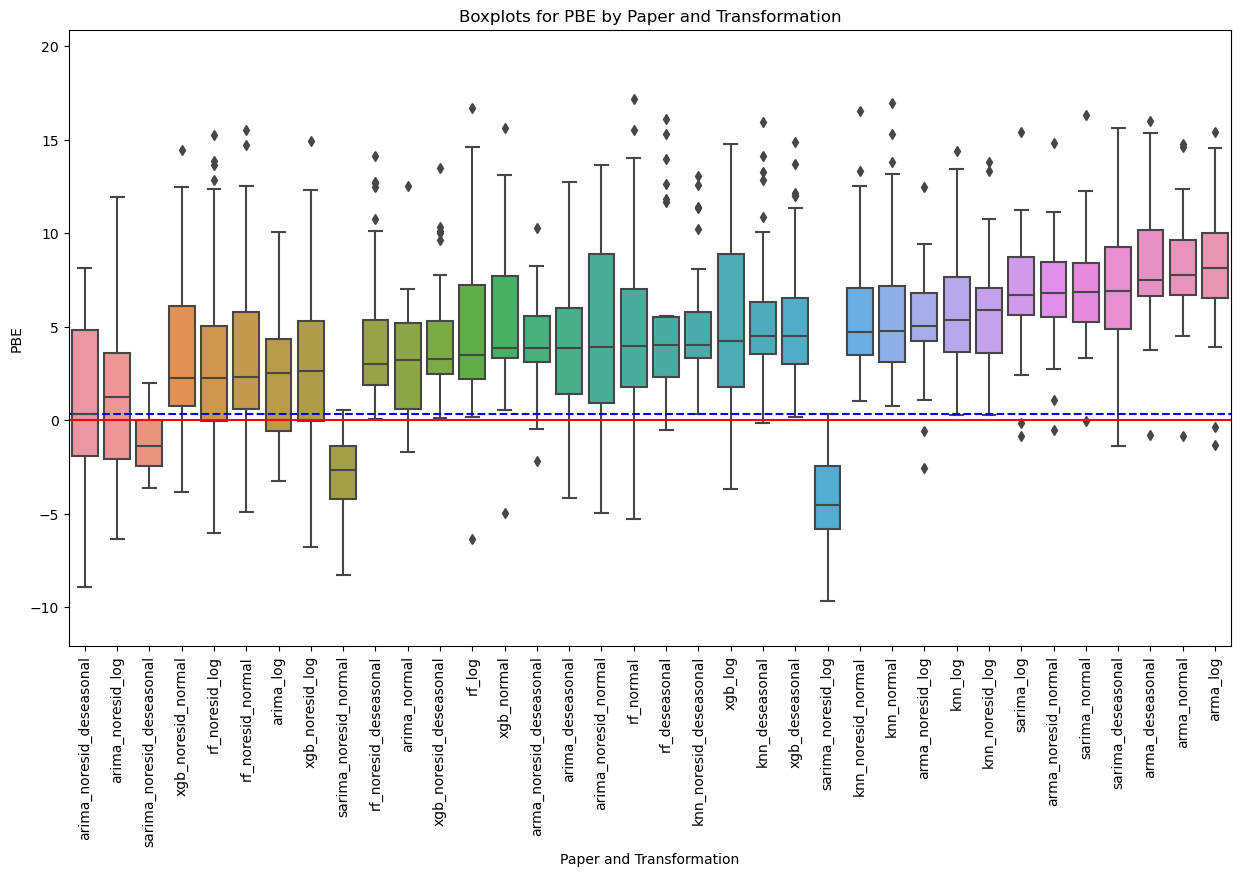

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_for_product(df, metric, product, papers, transformations):
    # Filtrar o DataFrame com base no produto fornecido
    df_filtered = df[df['PRODUCT'] == product]
    
    # Verificar se o DataFrame está vazio após a filtragem
    if df_filtered.empty:
        print(f"No data available for product: {product}")
        return
    
    # Criar uma lista para armazenar os DataFrames de cada combinação
    combined_dfs = []
    
    # Iterar sobre cada combinação de paper e transformation
    for paper in papers:
        for transformation in transformations:
            df_combination = df_filtered[(df_filtered['paper'] == paper) & (df_filtered['transformation'] == transformation)]
            
            # Verificar se o DataFrame está vazio após a filtragem
            if df_combination.empty:
                print(f"No data available for paper: {paper} and transformation: {transformation}")
                continue
            
            # Adicionar uma coluna auxiliar para identificar a combinação
            df_combination['Combination'] = f'{paper}_{transformation}'
            combined_dfs.append(df_combination)
    
    # Concatenar todos os DataFrames filtrados
    if combined_dfs:
        combined_df = pd.concat(combined_dfs)
        
        # Calcular a mediana absoluta para cada combinação
        medians = combined_df.groupby('Combination')[metric].median().abs().sort_values().index
        
        # Reordenar o DataFrame com base nas medianas
        combined_df['Combination'] = pd.Categorical(combined_df['Combination'], categories=medians, ordered=True)
        
        # Plotar o boxplot para a métrica fornecida, com diferentes combinações no eixo x
        plt.figure(figsize=(15, 8))
        ax = sns.boxplot(x='Combination', y=metric, data=combined_df)
        plt.title(f'Boxplots for {metric} by Paper and Transformation')
        plt.xlabel('Paper and Transformation')
        plt.ylabel(metric)
        plt.xticks(rotation=90)
        
        # Adicionar linha horizontal no ponto 0
        ax.axhline(0, color='red', linestyle='-')
        
        # Adicionar linha pontilhada na mediana do melhor boxplot
        best_median = combined_df.groupby('Combination')[metric].median().abs().min()
        ax.axhline(best_median, color='blue', linestyle='--')
        
        # Ajustar o intervalo do eixo y com base nos bigodes extremos
        y_min = combined_df.groupby('Combination')[metric].apply(lambda x: x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25))).min()
        y_max = combined_df.groupby('Combination')[metric].apply(lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))).max()
        ax.set_ylim([y_min, y_max])
        
        plt.show()
    else:
        print("No data available for the given combinations.")
# Exemplo de uso
validations = pd.read_csv('./validation/all_combinations.csv', sep=";")
metric = 'PBE'  # ou PBE, POCID, etc.
papers = ['arma', 'arima', 'sarima', 'arma_noresid', 'arima_noresid', 'sarima_noresid',
            'xgb', 'rf', 'knn', 'xgb_noresid', 'rf_noresid', 'knn_noresid']
transformations = ['normal', 'log', 'deseasonal']

plot_metric_for_product(validations, metric, produto, papers, transformations)


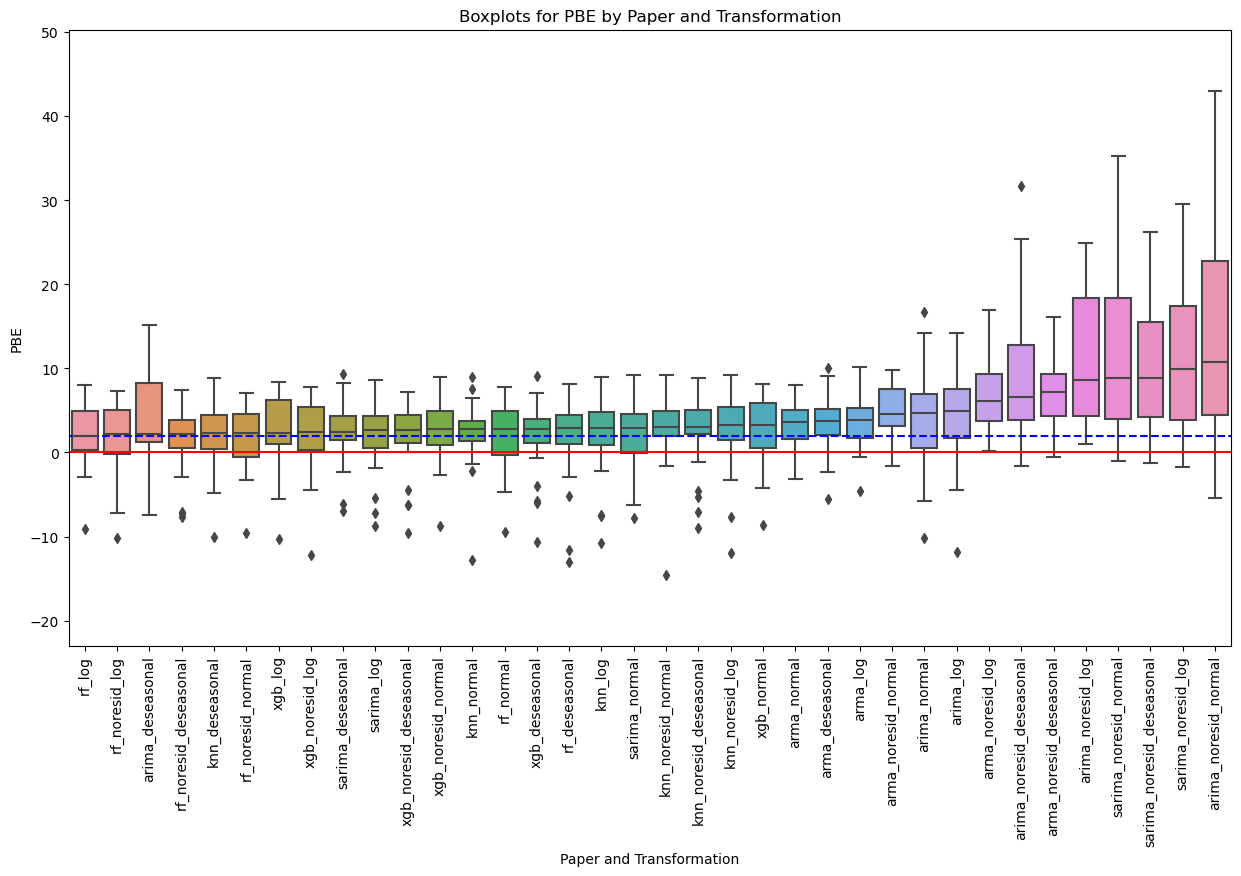

In [17]:
validations = pd.read_csv('./validation/train_2019_2.csv', sep=";")
metric = 'PBE'  # ou PBE, POCID, etc.
papers = ['arma', 'arima', 'sarima', 'arma_noresid', 'arima_noresid', 'sarima_noresid',
            'xgb', 'rf', 'knn', 'xgb_noresid', 'rf_noresid', 'knn_noresid']
transformations = ['normal', 'log', 'deseasonal']

plot_metric_for_product(validations, metric, produto, papers, transformations)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

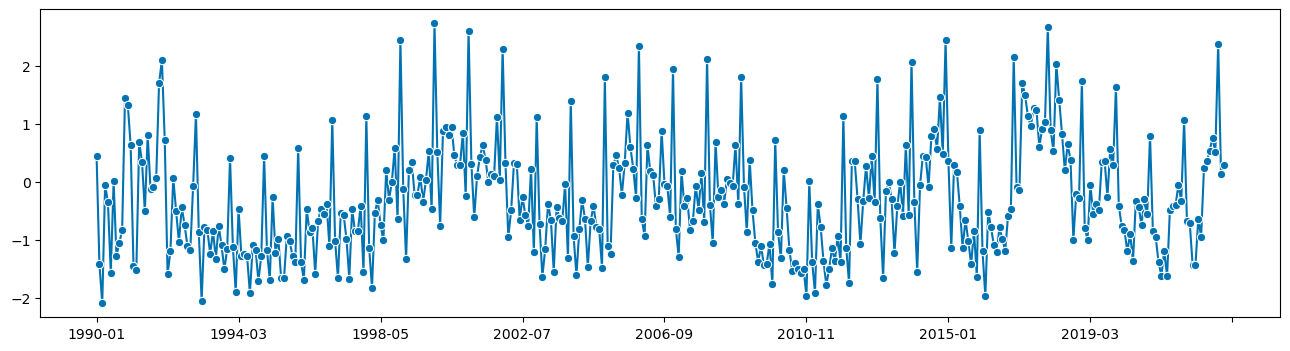

In [18]:
uf = "PR"
derivado = "gasolinac"
series = read_series(f"../datasets/venda/mensal/uf/{derivado}/mensal_{uf.lower()}_{derivado}.csv")
train, test = train_test_stats(series, horizon)

transformer = STLTransformer(sp=12) 
stl = transformer.fit(train)
train = stl.seasonal_ + stl.trend_

train_tf = transform_train(train, format="normal")
plot_series(train_tf)